In [1]:
# Import data analysis and visualisation packages
%matplotlib inline
import stan as ps
import patsy as pt
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import os

# Importing nest_asyncio is only necessary to run pystan in Jupyter Notebooks.
import nest_asyncio
nest_asyncio.apply()

# Specify the number of chains to the number of availible cpu's.
n_chains = os.cpu_count()
n_samples = 2000
#Convert to int so Stan will not crash below.
n_warmup = int(n_samples/2)
#Specify step size.
stepS = .8

In [2]:
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

# Bayesian multiple regression with hierachial priors

# Bayesian inference
<font size = "3"> Following the quick description of the classic multiple regression above its important to keep in mind that Bayesian analysis inference is derived from the application of Bayes rule $P(\theta \mid y) = \large \frac{P(y \mid \theta) \, P(\theta)}{P(y)}$ and as such while the following description of the Bayesian model is an equivalent to the classic multiple regression, it is fundamentally different, because its uses fully probabilistic modelling and the inferences are not based on sampling distributions</font>
    
<font size = "1"> For a fuller description see the Practicing Bayesian statistics markdown file within the Github repository.</font>

# Steps of Bayesian data analysis

<font size = "3"> Kruschke (2015) offers a step by step formulation for how to conduct a Bayesian analysis:

1. Identify the relevant data for question under investigation.

2. Define the descriptive (mathematical) model for the data.

3. Specify the Priors for the model. In the case of scientific research publication is the goal, as such the priors must be accepted by a skeptical audience. Much of this can be achieved using prior predcitve checks to ascertain if the priors are reasonable.

4. Using Bayes rule estimate the posterior for the parameters of the model using the likelihood and priors. Then interpret the parameter posteriors.

5. Conduct model checks. i.e. Posterior predictive checks.</font> 

<font size = "1">This notebook will follow this approach generally.</font> 

#  Step 1 - Identify the relevant data for question under investigation

The data above is taken from the multiple regression tutorial from Trinity open stats lab https://sites.trinity.edu/osl/data-sets-and-activities/regression-activities, for the original article from  which the data was derived, see, Atir, S., Rosenzweig, E., & Dunning, D. (2015). When knowledge knows no bounds: Self-perceived expertise predicts claims of impossible knowledge. Psychological Science, 26, 1295-1303.

## Study Description

The background for the data analysed below, is that experts play an ever increasing role in a ever increasing complex society with focused specialisation of said experts. A supposed phenomenen is that experts may be over convinced of their capabilities and no more than they actually do and are vulnerable to illsuionary thoughts. All resulting in overclaiming.(e.g. claiming impossible things).

Atir, Rosenzweig and Dunning (2015) study took 202 online participants and exposed them to a overclaiming task. Partipants completed a overclaiming task where participants responded with how much they each new about 15 finance terms. 3 of these terms did not exist. This is where any overclaiming was measured. The second task was self-percieved knowledge (personnel finance) questionaire. These two tasks were counterbalanced to control for order effects.

For the analysis we are going to analyse the associations between two predictor variable on proportion of overclaiming. The first of the 2 is the self-percieved knowledge score and the seocnd is the FNIRA score.

In [3]:
# Import data stored in the associated github.
url = "https://raw.githubusercontent.com/ebrlab/Statistical-methods-for-research-workers-bayes-for-psychologists-and-neuroscientists/master/wip/Data/Atir%20Rosenzweig%20Dunning%202015.csv"

# Read in csv of the data from Atir, S., Rosenzweig, E., & Dunning, D. (2015).
df = pd.read_csv(url)

# Output top three rows of the dataframe
df.head(3)

,id,order_of_tasks,self_perceived_knowledge,overclaiming_proportion,accuracy,FINRA_score
0,1,1,5.5,0.444444,0.250000,4
1,7,1,4.5,0.555556,0.194444,4
2,10,1,3.5,0.166667,0.347222,5


# Exploratory Data analysis

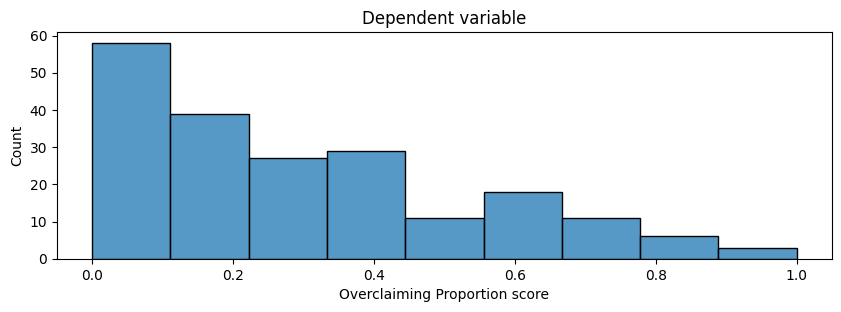

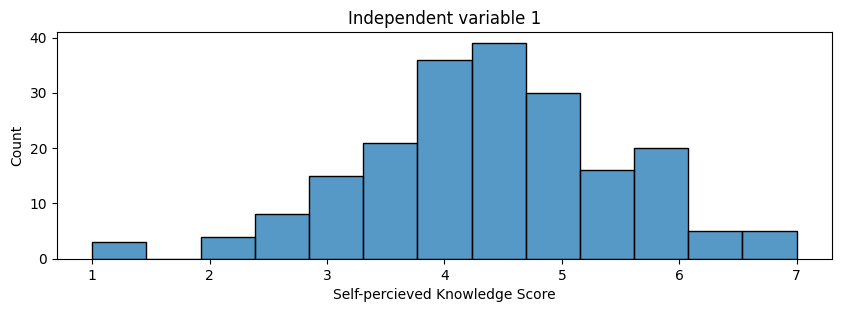

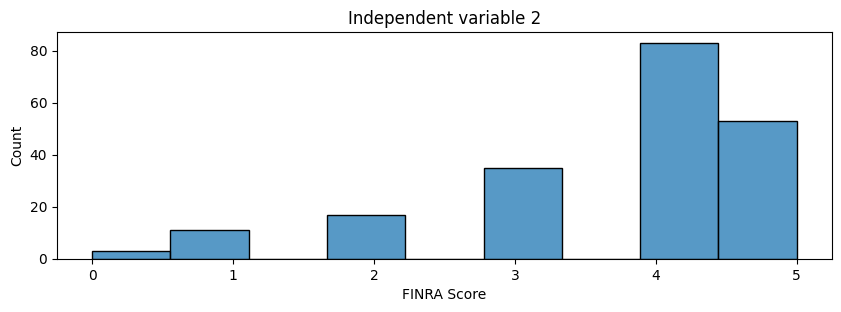

In [30]:
# Histogram of the dependent and independent variables

# Overclaiming_proportion

plt.figure(figsize=(10,10))
plt.subplot(311)
sns.histplot(df["overclaiming_proportion"])
plt.title('Dependent variable')
plt.xlabel("Overclaiming Proportion score" )
plt.show()

plt.figure(figsize=(10,10))
plt.subplot(312)
# Self percieved knowledge
sns.histplot(df["self_perceived_knowledge"], )
plt.title("Independent variable 1")
plt.xlabel("Self-percieved Knowledge Score" )
plt.show()

plt.figure(figsize=(10,10))
plt.subplot(313)
# Accuracy
sns.histplot(df["FINRA_score"])
plt.title('Independent variable 2')
plt.xlabel("FINRA Score")
plt.show()

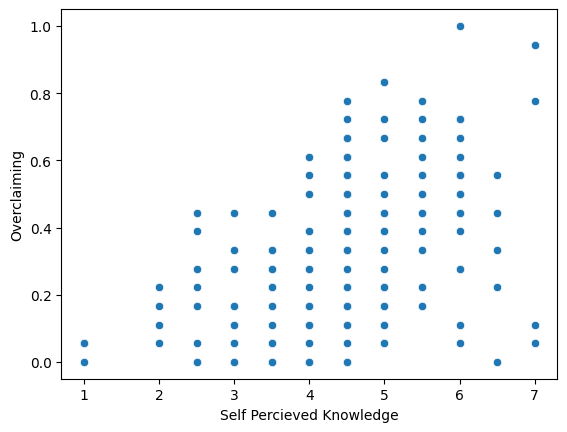

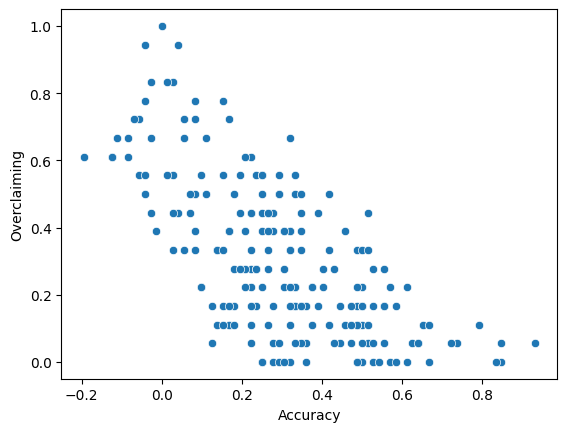

In [5]:
# Scatterplots
sns.scatterplot(x = "self_perceived_knowledge" , y = "overclaiming_proportion" , data=df).set(xlabel='Self Percieved Knowledge', ylabel='Overclaiming')
plt.show()

sns.scatterplot(x = "accuracy" , y = "overclaiming_proportion" , data=df).set(xlabel='Accuracy', ylabel='Overclaiming')
plt.show()

The model below is an example of a model that uses data informed default priors that are weakly informative and provide regularised inferences as specified by https://cran.r-project.org/web/packages/rstanarm/vignettes/priors.html#default-priors-and-scale-adjustments). The choice to use these defualts here is that it demonstrates this analytical option, as well as, demonstrating my own ignorance for how to set priors for this particular analysis problem, whilst at the same time attempting to avoid the use of uniform flat priors.

This use of defaults makes prior predictive checks mute as priors here are not aiming at placing resonable prior probabiltiy to the model parameters to the DGP outcome space, but to simple reguralise the inference. Finally, it is important to point out despite the use of priors here the nature of them being defaults informed by data means the analysis is no longer truely Bayesian (to the fullest extent of the phrase) and falls more towards an empirically Bayesian analysis as the priors are informed by the data.

# Step 2 - Define the descriptive statistical model  \begin{align*}
y_i &\sim Normal(\mu_i, \sigma) 
\\ \mu_i &= \beta_0 + \beta_1(x_1-\bar{x}_{1}) + \beta_2(x_2-\bar{x}_2)
\\ \beta_0 &\sim normal(m_y, 2.5 \cdot s_y)
\\ \beta_i &\sim normal(0, \sigma_\beta)
\\ \sigma &\sim exponential(1/s_y) 
\end{align*} 

In [32]:
# Stan model for conducting multiple regression with hierachy placed on beta parameters

Multiple_Regression_hier = """
data {
  int<lower=0> N;   // Sample size
  int<lower=0> K;   // Number of predictor variables
  matrix[N, K] x;   // Predictor variables (IV) matrix
  vector[N] y;      // Vector of Dependent variable (DV) values
  
  // prior settings for beta coeffiecents
  real mu_PS_beta;
  real sd_PS_beta;
  
  // prior settings for sigma coeffiecents
  real lamda_PS_sigma;
}

transformed data{
// Creating a new design matrix with the Independent variable of Inherence bias
// centered. 
matrix[N, K] x_transformed = x;

// Center the predictor variable
for (i in 1:K){
    x_transformed[,i] = x[,i] - mean(x[,i]);
    }
}
parameters {  
  real beta_0; // Intercept
  vector[K] beta;       // Coefficients for predictors
  real<lower=0> sigma;  // Standard deviation
  real<lower=0> sigma_beta;
}
model {
// Default priors
sigma_beta ~ normal(0, 20);
beta_0 ~ normal(mu_PS_beta, sd_PS_beta);
beta ~ normal(0, sigma_beta);
sigma ~ exponential(lamda_PS_sigma);

// likelihood
  y ~ normal(beta_0 + x_transformed * beta, sigma);  
}

generated quantities {
real yrep[N];
yrep = normal_rng(beta_0 + x_transformed * beta, sigma);
}
"""

In [36]:
#Generate design matrix for the regression analysis for use in the stan model above
x = np.asarray(pt.dmatrix(' ~ self_perceived_knowledge + accuracy', data = df))
x = x[:, 1:3]

array([[ 5.5       ,  0.25      ],
       [ 4.5       ,  0.19444444],
       [ 3.5       ,  0.34722222],
       [ 6.        , -0.05555556],
       [ 2.5       ,  0.16666667],
       [ 7.        , -0.04166667],
       [ 6.5       ,  0.84722222],
       [ 4.        ,  0.5       ],
       [ 4.5       , -0.08333333],
       [ 7.        ,  0.15277778],
       [ 4.        ,  0.61111111],
       [ 3.5       ,  0.15277778],
       [ 4.        ,  0.16666667],
       [ 5.        ,  0.61111111],
       [ 5.        ,  0.22222222],
       [ 5.        ,  0.48611111],
       [ 3.5       ,  0.16666667],
       [ 3.5       ,  0.25      ],
       [ 6.        ,  0.29166667],
       [ 4.5       ,  0.41666667],
       [ 5.        ,  0.02777778],
       [ 6.        ,  0.18055556],
       [ 5.        ,  0.22222222],
       [ 4.5       ,  0.29166667],
       [ 6.        ,  0.34722222],
       [ 3.5       ,  0.40277778],
       [ 4.5       ,  0.48611111],
       [ 5.        ,  0.48611111],
       [ 4.5       ,

In [34]:
# Generating a python dictionary for passing to the stan model specifiesd above.
data = {
    'N': len(df),
    'K': x.shape[1],
    'x': x,
    'y': df["overclaiming_proportion"].values,
    
    # Set prior values outside of stan based on rstanarm implementation.
    # Priors for the beta parameter prior means
    'mu_PS_beta': np.mean(df["overclaiming_proportion"]),
    
    # Priors for the beta parameter prior standard deviations
    'sd_PS_beta': 2.5 * np.std(df["overclaiming_proportion"]), 
                  
    # Prior value for the sigma parameter
    'lamda_PS_sigma': 1/np.std(df["overclaiming_proportion"])   
}

In [37]:
# Code below compiles the Stan model specified above. Warnings are bug with stan
# prior predictive checks reveal prior on the parameters are recognised when run.
sm = ps.build(Multiple_Regression_hier, data = data)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_qwio8ylo/model_rp3hoxct.stan', line 44, column 0: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_qwio8ylo/model_rp3hoxct.stan', line 34, column 23: Argument
    20 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [38]:
# Fiting model to the complied stan model above with 4 chains 
fit = sm.sample(num_chains = n_chains , num_samples = n_samples, num_warmup = n_warmup, stepsize = stepS)

Sampling:   0%
Sampling:  12% (3000/24000)
Sampling:  25% (6000/24000)
Sampling:  38% (9000/24000)
Sampling:  50% (12000/24000)
Sampling:  62% (15000/24000)
Sampling:  75% (18000/24000)
Sampling:  88% (21000/24000)
Sampling: 100% (24000/24000)
Sampling: 100% (24000/24000), done.
Messages received during sampling:
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.64 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation

In [39]:
fit_df = fit.to_frame()
az.summary(fit, var_names = ['beta_0', 'beta', 'sigma','sigma_beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,0.308,0.009,0.291,0.325,0.000,0.000,20195.0,10744.0,1.0
beta[0],0.100,0.008,0.085,0.114,0.000,0.000,20909.0,10945.0,1.0
beta[1],-0.752,0.042,-0.832,-0.674,0.000,0.000,18986.0,11778.0,1.0
sigma,0.127,0.006,0.116,0.140,0.000,0.000,18620.0,11142.0,1.0
sigma_beta,2.124,3.217,0.191,6.673,0.035,0.025,13382.0,9523.0,1.0


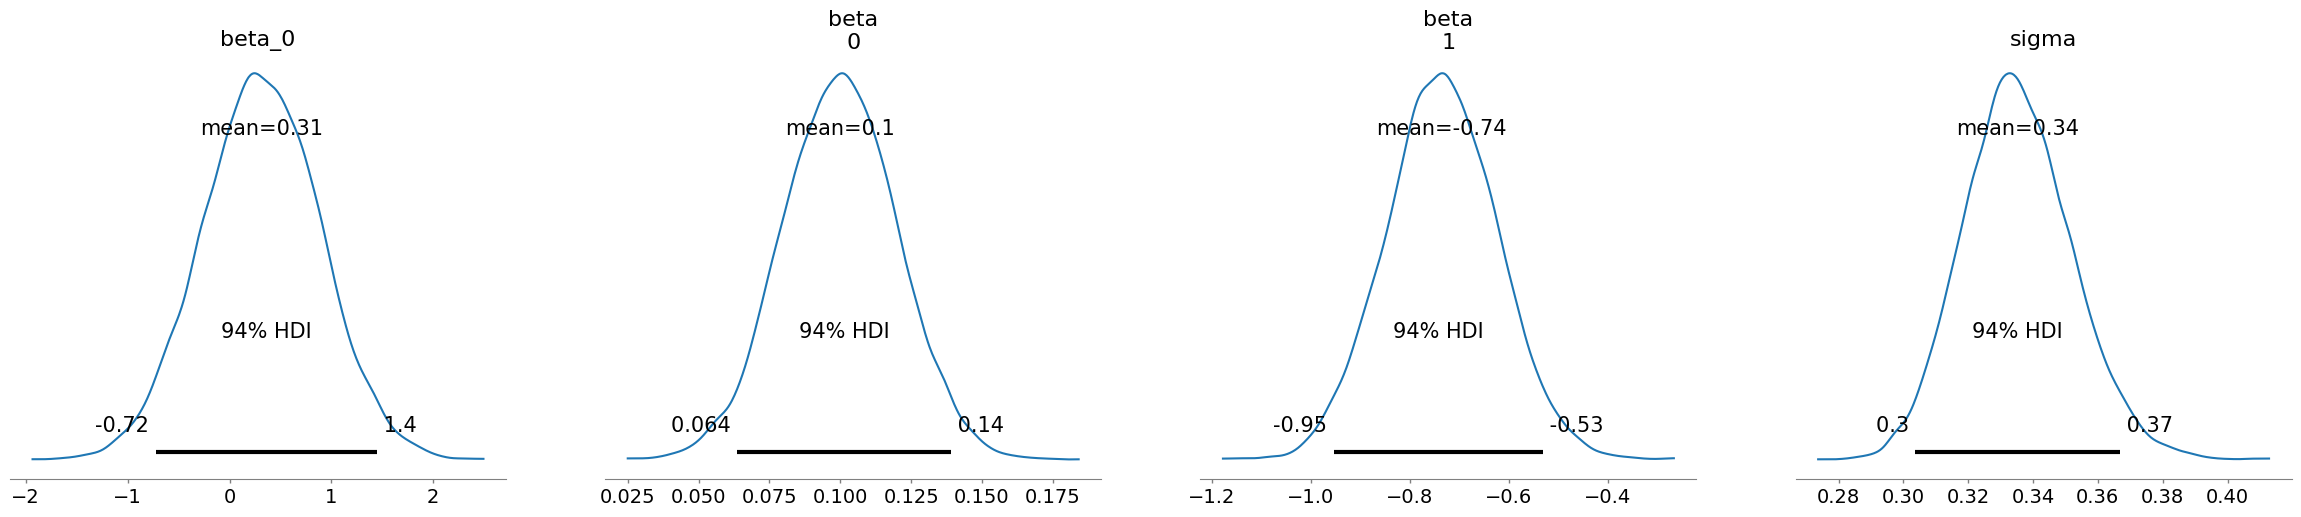

In [12]:
az.plot_posterior(fit, var_names=("beta_0", "beta", "sigma"));

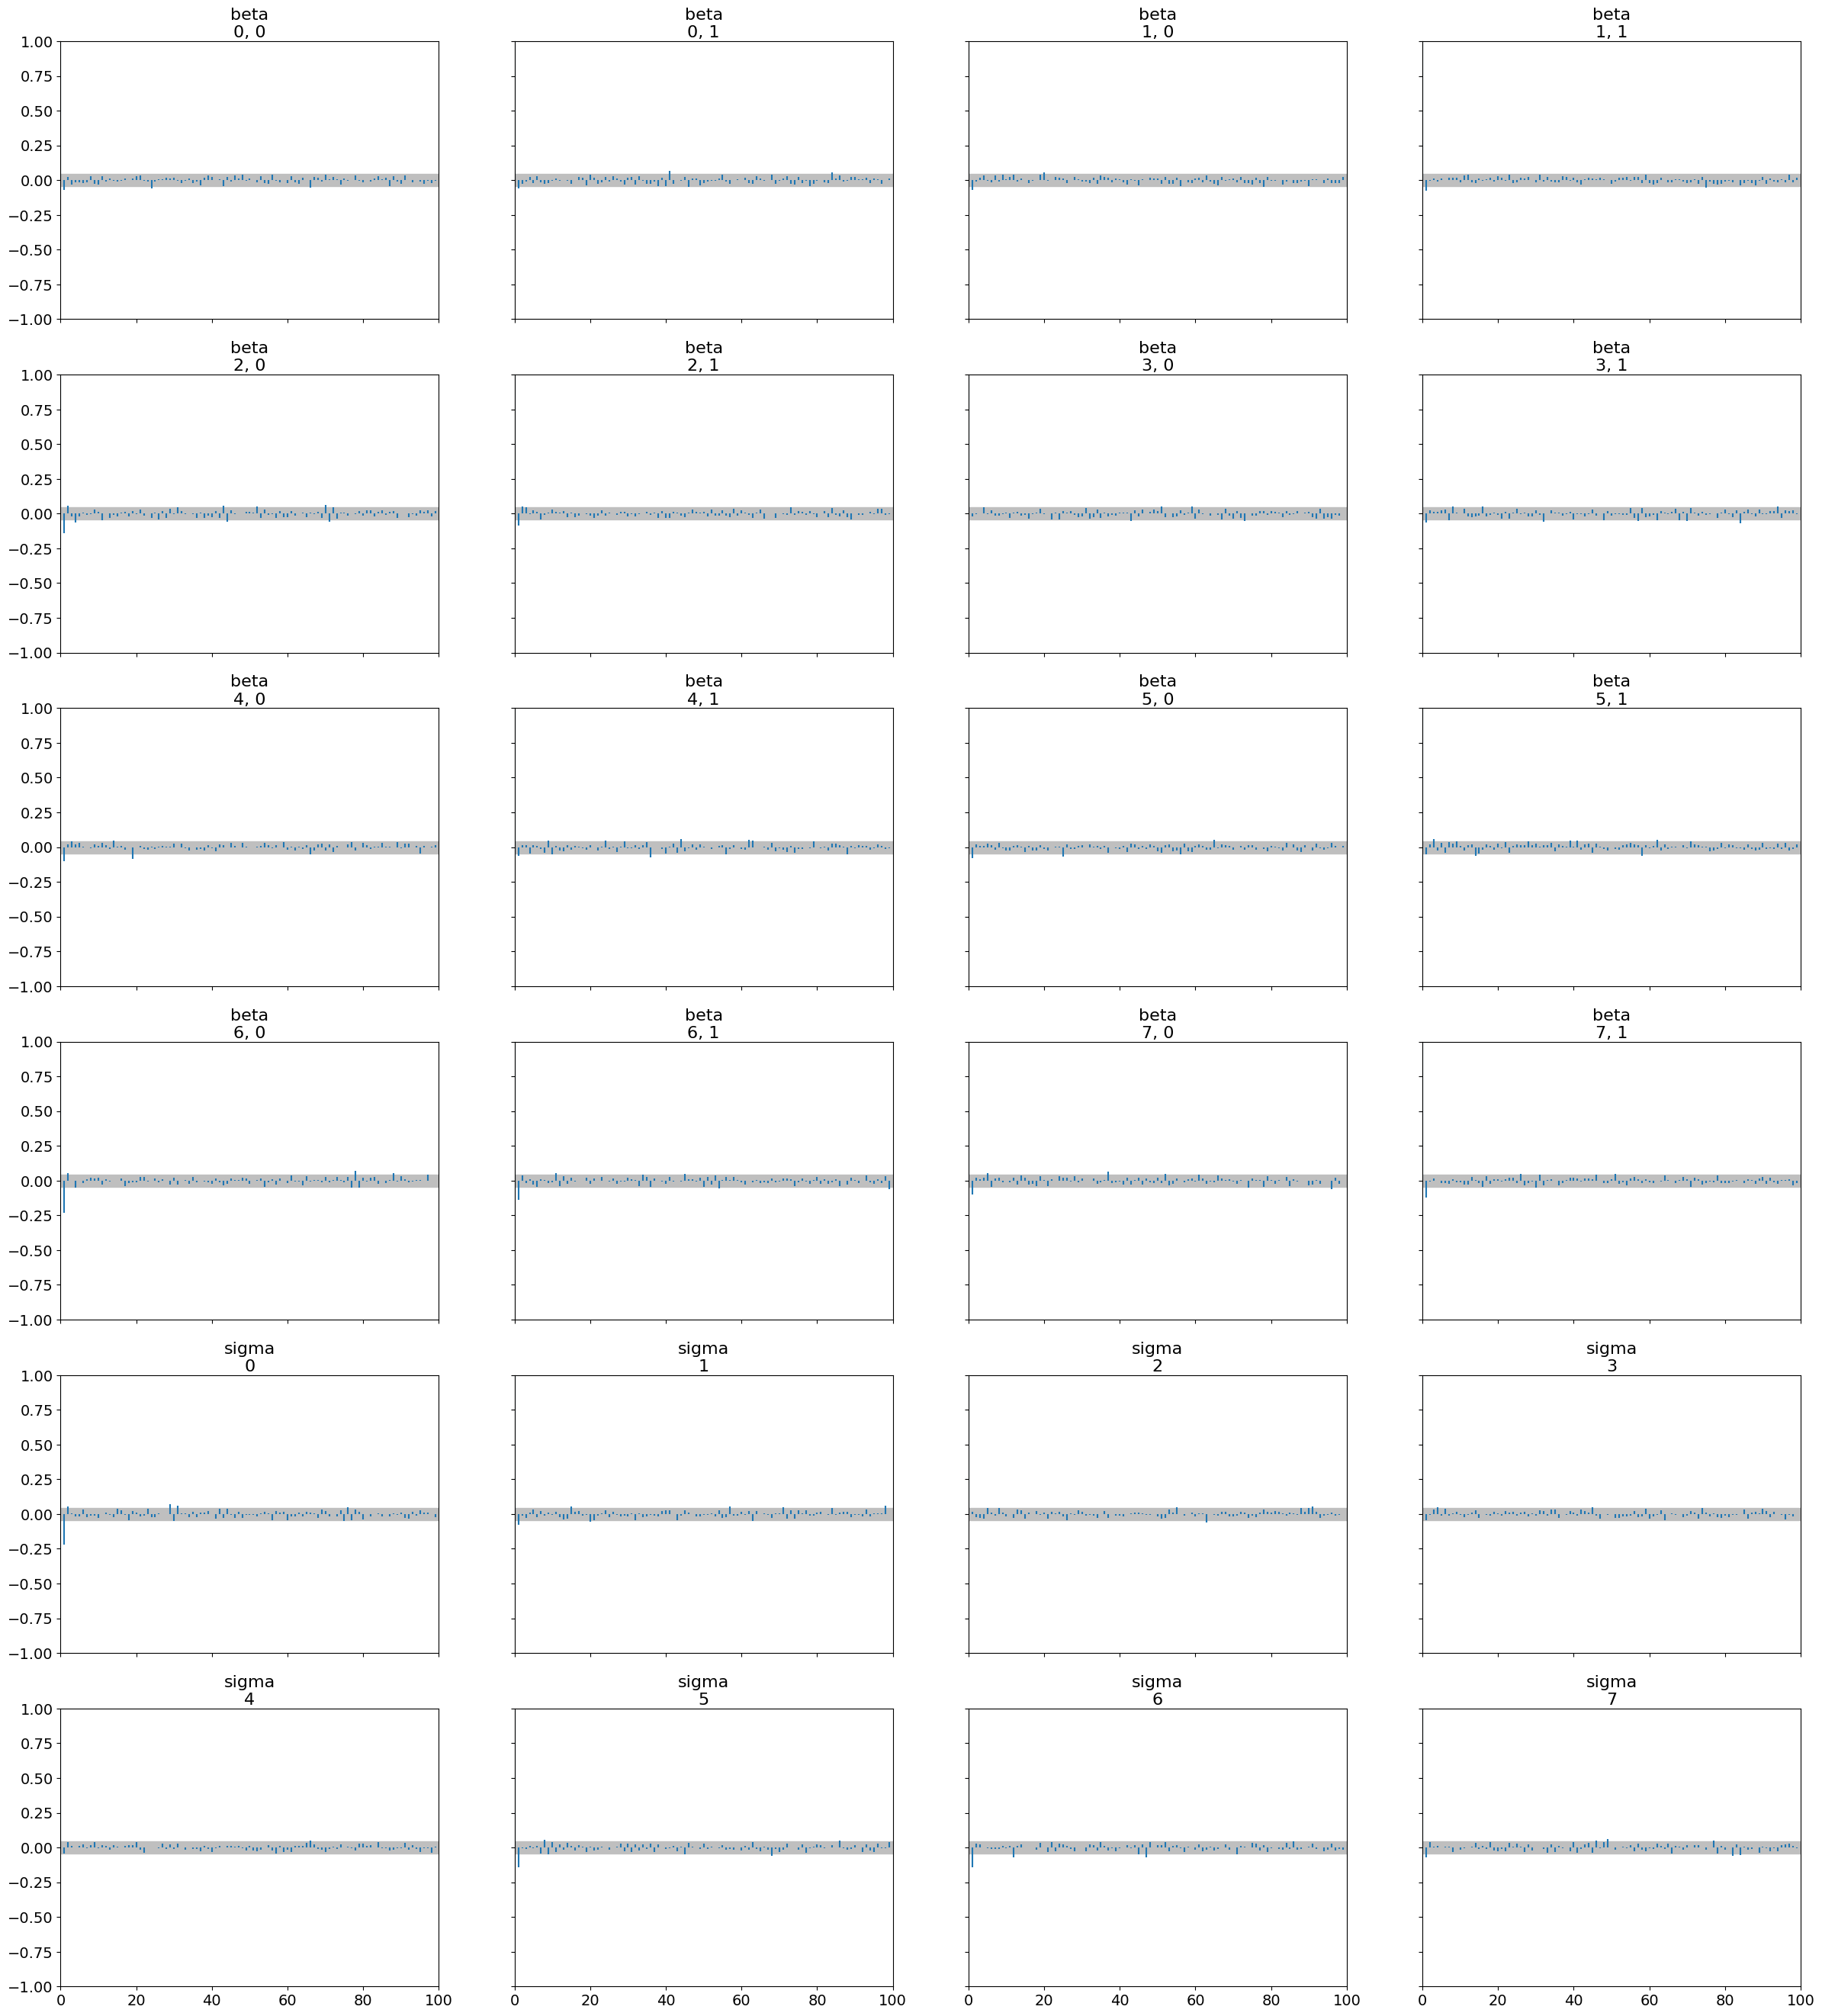

In [13]:
az.plot_autocorr(fit,var_names=("beta", "sigma"));

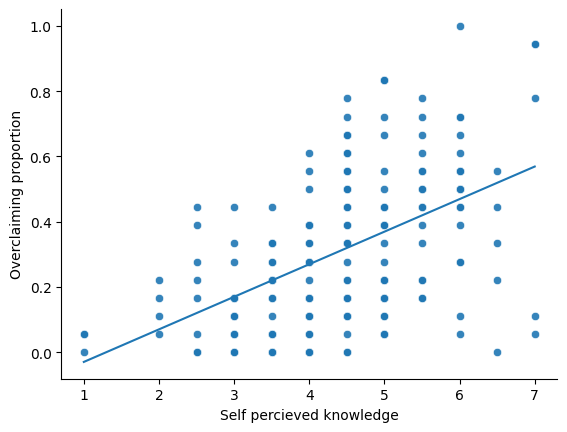

In [14]:
x_vals1 = np.linspace(1,7,100)
xbar1 = np.mean(df['self_perceived_knowledge'])
y_vals1 = np.mean(fit_df['beta_0']) + np.mean(fit_df['beta.1']) * (x_vals1 - xbar1)
sns.scatterplot(data = df, x = 'self_perceived_knowledge', y = 'overclaiming_proportion', alpha = .9);
sns.despine(top = True, right = True,);
plt.plot(x_vals1, y_vals1, '-');
plt.xlabel('Self percieved knowledge');
plt.ylabel('Overclaiming proportion');

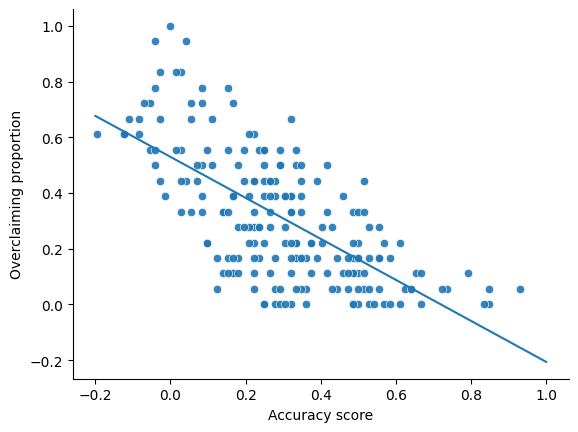

In [15]:
# Plot MAP line for accuracy covariate aga
x_vals2 = np.linspace(-.2, 1, 100)
xbar2 = np.mean(df['accuracy'])
y_vals2 = np.mean(fit_df['beta_0']) + np.mean(fit_df['beta.2']) * (x_vals2 - xbar2)
sns.scatterplot(data = df, x = 'accuracy', y = 'overclaiming_proportion', alpha = .9);
sns.despine(top = True, right = True,);
plt.plot(x_vals2, y_vals2, '-');
plt.xlabel('Accuracy score');
plt.ylabel('Overclaiming proportion');

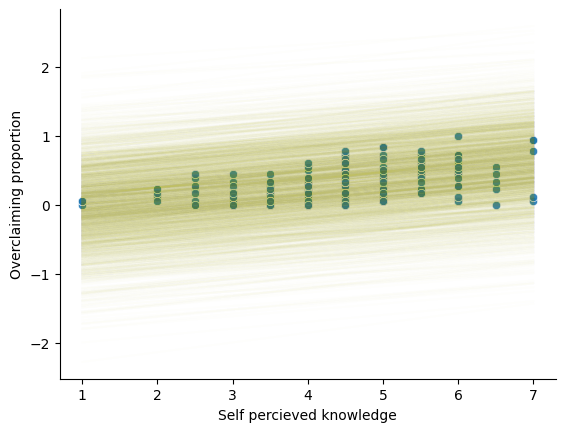

In [16]:
for i in range(0, 2000):
    # Mean centred
    y_vals1 = np.mean(fit_df['beta_0'][i]) + np.mean(fit_df['beta.1'][i]) * (x_vals1 - xbar1)
    plt.plot(x_vals1, y_vals1, '-y', alpha=0.01)

sns.scatterplot(data = df, x = 'self_perceived_knowledge', y = 'overclaiming_proportion', alpha = .9)
sns.despine(top = True, right = True,);
plt.xlabel('Self percieved knowledge');
plt.ylabel('Overclaiming proportion');

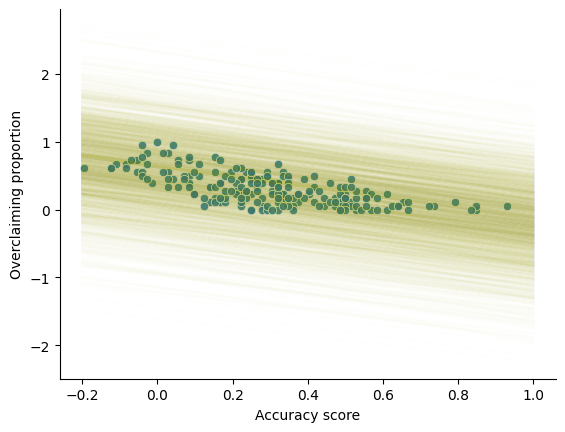

In [17]:
# Plot a set of credible regression lines
for i in range(0, 2000):
    # Mean centred
    y_vals2 = np.mean(fit_df['beta_0'][i]) + np.mean(fit_df['beta.2'][i]) * (x_vals2 - xbar2)
    plt.plot(x_vals2, y_vals2, '-y', alpha = 0.01)

sns.scatterplot(data = df, x = 'accuracy', y = 'overclaiming_proportion', alpha = .9);
sns.despine(top = True, right = True,);
plt.xlabel('Accuracy score');
plt.ylabel('Overclaiming proportion');

In [18]:
# Convert pystan fit object to IO for Arviz functions.
idata = az.from_pystan(posterior=fit,posterior_model = sm, posterior_predictive=['yrep'],observed_data= 'y')

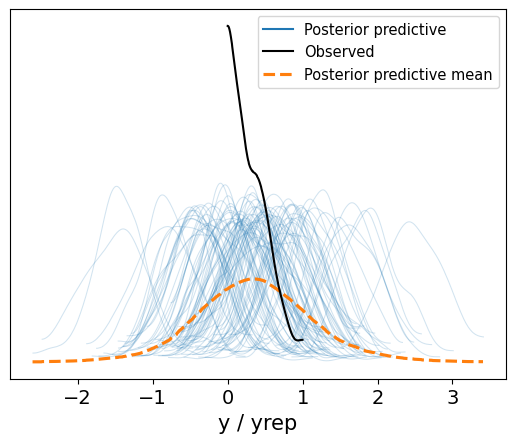

In [19]:
# Plot posterior simulated data sets for posterior predictive check
az.plot_ppc(idata, data_pairs = {"y" : "yrep"}, num_pp_samples= 100);

# References

Atir, S., Rosenzweig, E., & Dunning, D. (2015). When knowledge knows no bounds: Self-perceived expertise predicts claims of impossible knowledge. Psychological Science, 26, 1295-1303.

Gabry, J., Simpson, D., Vehtari, A., Betancourt, M., & Gelman, A. (2019). Visualization in Bayesian workflow. Journal of the Royal Statistical Society: Series A (Statistics in Society), 182(2), 389-402.

Goodrich, B., Gabry, J., Ali, I., & Brilleman, S. (2018). rstanarm: Bayesian applied regression modeling via Stan. R package version, 2(4), 1758.
    
    
Kruschke, J. (2015). Doing Bayesian data analysis: A tutorial with R, JAGS and Stan. Oxford, England: Academic Press.   

Kruschke, J. K. (2018). Rejecting or accepting parameter values in Bayesian estimation. Advances in Methods and Practices in Psychological Science, 1(2), 270-280.

Liu, F., & Kong, Y. (2015). zoib: An R Package for Bayesian Inference for Beta Regression and Zero/One Inflated Beta Regression. R J., 7(2), 34.

Makowski, D., Ben-Shachar, M. S., Chen, S. H., & Lüdecke, D. (2019). Indices of effect existence and significance in the Bayesian framework. Frontiers in psychology, 10, 2767.
    
McElreath, R. (2020). Statistical rethinking: A Bayesian course with examples in R and Stan.Boca Raton: CRC Press.

Vehtari, A., Gelman, A., Simpson, D., Carpenter, B., & Bürkner, P. C. (2019). Rank-normalization, folding, and localization: An improved $\widehat {R} $ for assessing convergence of MCMC. arXiv preprint arXiv:1903.08008.